In [13]:
import numpy as np
import pandas as pd
import scipy.io
import cPickle as pickle
import gzip
from urllib import urlretrieve
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
url = 'http://ufldl.stanford.edu/housenumbers/'
data_dir = "data/"
last_percent_reported = None

# hook for download progress reporting
def download_progress_hook(count, blockSize, totalSize):
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
  file_path = data_dir + filename
  if force or not os.path.exists(file_path):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, file_path, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(file_path)
  return file_path

# download if not already downloaded
train_matfile = maybe_download('train_32x32.mat')
test_matfile = maybe_download('test_32x32.mat')
extra_matfile = maybe_download('extra_32x32.mat')

('Attempting to download:', 'test_32x32.mat')
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
('Attempting to download:', 'extra_32x32.mat')
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!


In [17]:
train_data   = scipy.io.loadmat(train_matfile, variable_names='X').get('X')
train_labels = scipy.io.loadmat(train_matfile, variable_names='y').get('y')
test_data    = scipy.io.loadmat(test_matfile, variable_names='X').get('X')
test_labels  = scipy.io.loadmat(test_matfile, variable_names='y').get('y')
extra_data   = scipy.io.loadmat(extra_matfile, variable_names='X').get('X')
extra_labels = scipy.io.loadmat(extra_matfile, variable_names='y').get('y')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(extra_data.shape, extra_labels.shape)

# some 0s are labelled as 10
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

# merge extra + train and reshape to [img_idx, x_dim, y_dim, color_channel]
train_data = np.concatenate((extra_data, train_data), axis=3).transpose((3,0,1,2))
train_labels = np.concatenate((extra_labels, train_labels), axis=0)[:,0]

test_data = test_data.transpose((3,0,1,2))
test_labels = test_labels[:,0]

del extra_data
del extra_labels

# normalize between 0..1
train_data = np.multiply(train_data, 1.0 / 255.0)
test_data = np.multiply(test_data, 1.0 / 255.0)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

((32, 32, 3, 73257), (73257, 1))
((32, 32, 3, 26032), (26032, 1))
((32, 32, 3, 531131), (531131, 1))
((604388, 32, 32, 3), (604388,))
((26032, 32, 32, 3), (26032,))


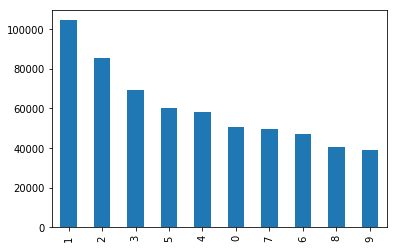

In [4]:
df = pd.DataFrame(train_labels)
df[0].value_counts().plot(kind="bar")

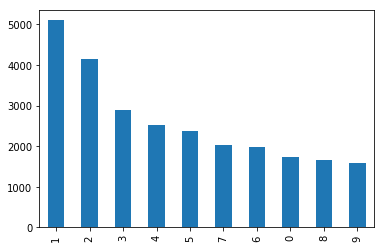

In [5]:
df = pd.DataFrame(test_labels)
df[0].value_counts().plot(kind="bar")

##### Relatively small class imbalance exists, curious if this affects performance of 8's or 9's.

In [18]:
def dense_to_one_hot(labels_dense, num_classes=10):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

# convert scalar labels to one hot labels, i.e. 2 to [0, 0, 2, 0,...]
train_labels = dense_to_one_hot(train_labels)
test_labels = dense_to_one_hot(test_labels)

# save down labels
np.save(data_dir+"svhn_train_labels", train_labels)
np.save(data_dir+"svhn_test_labels", test_labels)

In [19]:
# save down image data
np.save(data_dir+"svhn_color_train", train_data)
np.save(data_dir+"svhn_color_test", test_data)

In [20]:
# Using Method from: http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf
# Fast, contrast enhancing grayscale conversion
def rbg2gray(img):
    img = img.astype(float)
    return np.dot(img, [[0.2989],[0.5870],[0.1140]])

# Global Contrast Normalization
# As per: https://github.com/hangyao/street_view_house_numbers/blob/master/1_preprocess_single.ipynb
def GCN(image, min_divisor=1e-4):
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    
    image_GCN = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_GCN

# make 'em grey
train_data_gray = rbg2gray(train_data)[:,:,:,0]
test_data_gray = rbg2gray(test_data)[:,:,:,0]

# normalize contrast
train_data_gcn = GCN(train_data_gray)
test_data_gcn = GCN(test_data_gray)

print(train_data_gcn.shape, train_labels.shape)
print(test_data_gcn.shape, test_labels.shape)

((604388, 32, 32), (604388, 10))
((26032, 32, 32), (26032, 10))


In [24]:
# save 'em down
np.save("data/svhn_grayscale_train", train_data_gcn)
np.save("data/svhn_grayscale_test", test_data_gcn)

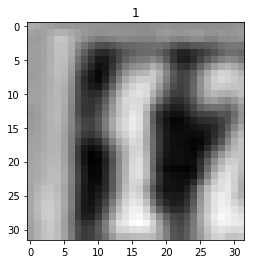

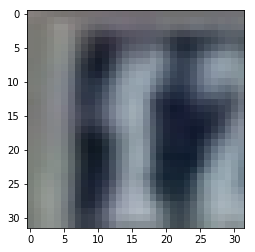

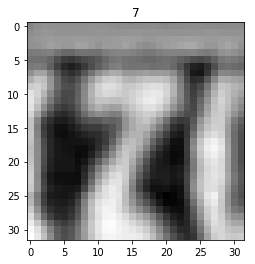

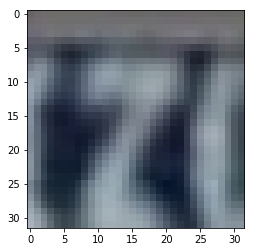

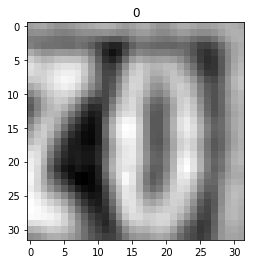

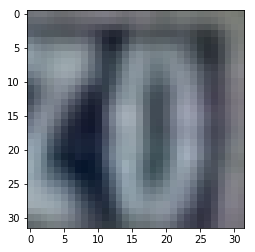

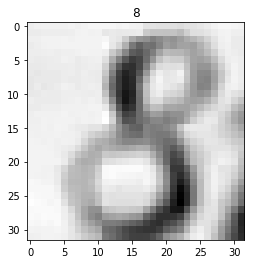

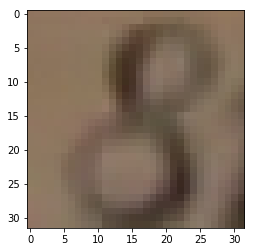

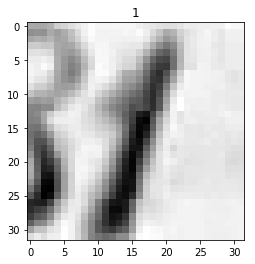

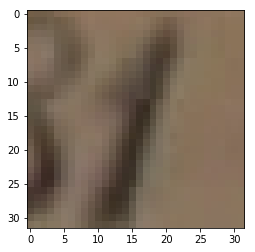

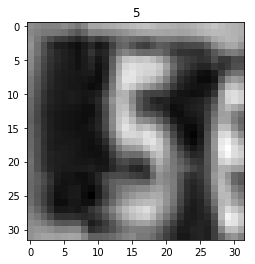

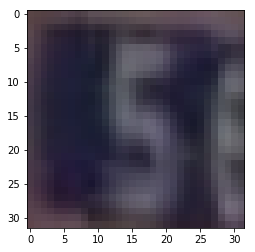

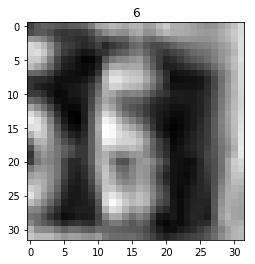

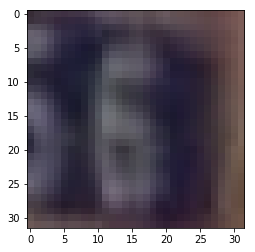

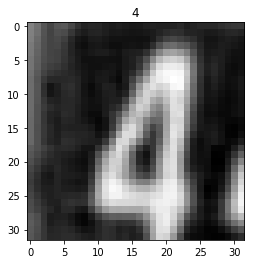

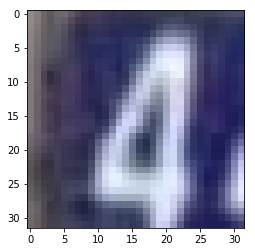

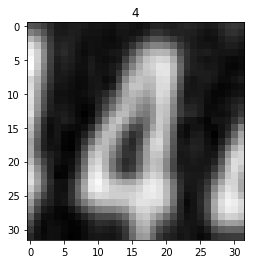

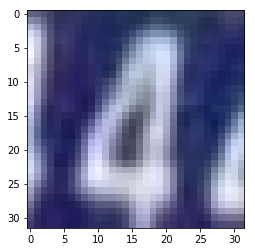

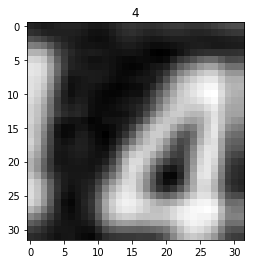

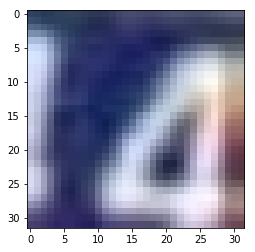

In [23]:
for i in range(15, 25):
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  lbl = np.argmax(train_labels[i])
  ax.set_title(lbl)

  img_gcn = train_data_gcn[i]
  plt.imshow(img_gcn, cmap="gray"); plt.show()
  
  img_org = train_data[i]
  plt.imshow(img_org); plt.show()